In [1]:
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
import random

# Data Treatment

All data provided by the company were added to a single .csv file (.csv simplifies the reading because allows Numpy to read it, instead of Pandas). The chosen Output Variable was the Mill Discharge Solids %. The Inputs are listed in the code below, and are: Cyclone Dissolution Water, Mill Dissolution Water, Mill Feed (ton/hr), PSI data, Cyclone Pressure (in Psi) and Mill Power (kWh). 

For the outputs, since there were less samples than the inputs, and many were not paired, a statistical study was made and concluded that it followed a normal distribution with very high R², and therefore with a small effort was possible to complete the absent data trying to maintain a minimum physical coherence between the variables, beeing higher or lower depending on the Inputs. This is obviously not ideal, but might be a problem faced in real world problems. It could, however, be easily solved by taking data in a more careful way, keeping the parity (X,Y) of inputs and outputs to achieve an ever better result.
The "non-normal" samples, corresponding to operation stops ou reduced capacity were also not taken in consideration because it would imply in a higher Variance, which could make the model impossible to train properly on the data. 

In [2]:
#Data_Unified Labels
#Cyc Water, Mill Water , Mill Feed , PSI  , Cyc Pressure , Mill Power , % Solids
data = np.loadtxt("Dados_Filtrados_Unificado_csv.csv", delimiter = ',')

x_data = data[:,0:6]
y_data = data[:,6]

In the code below, our data is separated in two sets: the training and test. The training data will be used by the model to adjust it's parameters, while the test data will be an indicative of how accurate our model is. In this case, 60% of the samples are used as training, while the remaining 40% are used as test. This number is arbitrary, but using too much for training would imply in Overfitting, and our model would not be relevant when facing new data. The "random_state=5" piece is just a way to allow other runs of the code to start from the same point, keeping the same initialized values.

In [3]:
(train_data, test_data, 
     train_targets, test_targets) = train_test_split(x_data, y_data, test_size=.4, random_state=5)

# Statistical Treatment

With high variance values, the model becomes very hard to map the inputs to the outputs properly. This can be easily solved by a procedure called Normalization. By subtracting the mean and dividing the results by the standart deviation, we now have a set with mean=0 and unity standart deviation, making the training and adjusting process much easier and more accurate. 

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

# Creating the Model

Here we define a function for effectively creat and compile the neural network model. Since this is a numerical regression problem, there are some "golden rules" to be followed to achieve a better result:
    - Using few hidden layers in order to prevent Overfitting
    - Mixing non-linear activation functions to include non-linear relationships between the variables
    - Using a linear output activation
With that in mind, 2 hidden layers proved to be enough, each with 64 neurons and using the ReLU activation function. Others combinations were tested, but this one was the best. 
For the Loss Function, because it's a numerical regression, the mean_squared_error was chosen. 

In [5]:
def build_model():
    #Building the Network:
    model = models.Sequential()
    
    #Inputs and Hidden Layers
    model.add(Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],))) # Dim = 6
    model.add(Dense(64, activation = 'relu'))
    
    #Output
    model.add(Dense(1))
    
    #Compiling the model
    model.compile(loss = "mean_squared_error", optimizer = "Adam", metrics = ['mean_absolute_error'])
    return model

# K-Fold Cross Validation
This is a very clever procedure to make the best use of a low number of samples. Since we had ~440 samples in total, this technique becomes essential to achieve a better result. It basically divides the training and test sets in K folds (in our case, K=4), and runs different combinations of training and test between those K folds. Suposing [K1, K2, K3, K4] are the folds, we first use [K1,K2,K3] for training and [K4] for testing, then [K2,K3,K4] for training and [K1] for test, and so on. In the end, we get 4 different metrics for the error commited, and the mean value of these 4 values is a much better and reliable metric than any of the single values.
We also start to keep track of the time required to run the programe since it might become another important parameter. 
For the training process, we start with a small number of epochs (number of passes through the data by the algorithm) of 50. The higher the epochs, the bigger the time required and, up to some key value, the lower the error. 

In [6]:
#First fitting with 50 epochs
num_epochs = 50

#Perfmorming k-fold cross validation
k = 4
#Keep track on the time required
start = time.time()

num_val_samples = len(train_data) // k
all_scores = []

for i in range(k):
    print('Processing Fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
end = time.time()
print("Time Elapsed:", end - start, "s")
    

Processing Fold # 0
Processing Fold # 1
Processing Fold # 2
Processing Fold # 3
Time Elapsed: 25.46401619911194 s


Here we have all the mean absolut erros for each k-fold. There are some high differences between each other (the highest error is more than twice the smaller). So we compute te mean error for the 4 folds and have a much more reliable metric. In this point, the average error is 0.0203. Since we are computing a Percentage, this represents a 2% error. Not much interesting since this is the order of the standart deviation of the output data. 

In [7]:
print("Mean Absolut Errors: ")
for i in range(k):
    print("Fold #",i,":", all_scores[i])

Mean Absolut Errors: 
Fold # 0 : 0.01602446942618399
Fold # 1 : 0.02616492004105539
Fold # 2 : 0.012560464216001106
Fold # 3 : 0.012456759358897354


In [8]:
print("Mean Error: ")
np.mean(all_scores)

Mean Error: 


0.016801653260534462

In [9]:
#Cleaning memory cached
from tensorflow.keras import backend as K
K.clear_session()

We now increase the number of epochs to 800 to see how much (if any) the error will decrease. We also do a clever "trick" of storing every error values for each different epoch in a new variable that we will use ahead to see the relation between error and epochs number. The time required for the training now should be much higher than the previous test.

In [10]:
#Increasing number of Epochs to 800 for better perfomance
num_epochs = 800
all_mae_histories = []
start = time.time()
all_scores_improved =[]

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores_improved.append(val_mae)
    
end = time.time()
print("Time Elapsed:", end - start, "s")

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Time Elapsed: 411.3039240837097 s


We can see that the time required grew by a factor of 17.6, but the error became half of the previous, to 0.00987, or a bit ubder 1%. This value can be a little different for different runs, of if the network is run more than one time on the same data set, but it's already a much better metric, which means that this model can predict the Mill Discharge Solids % with less 1% error. We will discuss later how to lower even more this error.  

In [11]:
print("Mean Absolut Errors for 800 epochs: ")
for i in range(k):
    print("Fold #",i,":", all_scores_improved[i])

Mean Absolut Errors for 800 epochs: 
Fold # 0 : 0.009373008301763824
Fold # 1 : 0.01010753530444521
Fold # 2 : 0.010726943160548355
Fold # 3 : 0.009258960232590183


In [12]:
print("Mean Error: ")
np.mean(all_scores_improved)

Mean Error: 


0.009866611749836893

Although a better metric was achieved, the time required was also much higher. With larger datasets, this could become an issue, since the network would be trained a lot of times as more and more samples were being added. To solve this, we compute the following plot of Epochs vs Validation Error.

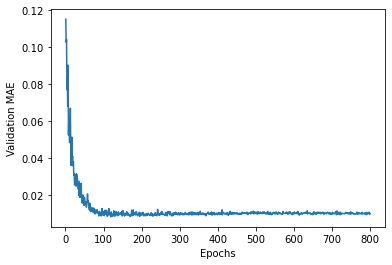

In [14]:
#Plotting the average mean absolute error
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

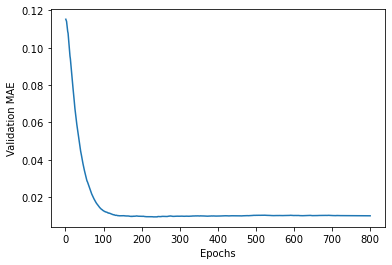

In [15]:
#Smoothing the curve for better visualization
#and using exponential moving averages instead of points
def smooth_curve(points, factor=0.95):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history)

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

The first graph is already pretty clear and easy to read, but there are some small peaks that could cause some imprecision. We solve this by using a "smoother" curve, replacing the original points by an exponential-moving average. With this very clear and smooth plot, we can see that after around 150 Epochs the error stabilized, keeping constant regarding of the epochs number. There's now only one more paramter to tune: the batch size. So fat we have only used a batch size equals to 1, but we could improve this to a more specific number. In general, lower batch size values increase the learning rate, but tend to present higher validation variances. Bigger sizes have a slower learning rate, but tend to generate more stable models. We will check this with the plots below, for 200 epochs. 

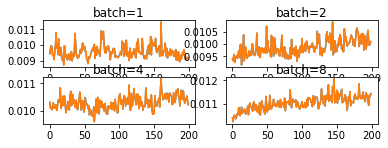

Time Elapsed: 70.55380535125732 s


In [16]:
from matplotlib import pyplot
start = time.time()
#Comparing different Batch Sizes
#Create learning curves for different batch sizes
batch_sizes = [1, 2, 4, 8]
for i in range(len(batch_sizes)):
    #Determine the plot number
    plot_no = 420 + (i+1)
    pyplot.subplot(plot_no)
    n_batch = batch_sizes[i]
    #Fit model and plot learning curves for a batch size
    history = model.fit(train_data, train_targets,
                        validation_data=(test_data, test_targets),
                        epochs=200, batch_size=batch_sizes[i], verbose=0)
    pyplot.plot(history.history['val_mean_absolute_error'], label='train')
    pyplot.plot(history.history['val_mean_absolute_error'], label='test')
    pyplot.title('batch='+str(n_batch), pad=-40)
#Show learning curves
pyplot.show()
end = time.time()
print("Time Elapsed:", end - start, "s")

These plots are a little harder to read due to Python sloppy formating , but they represent the validation error vs epochs number for different batch sizes. It's not clear to see any particular advantage or disadvantage for each of them, but the batch=1 seems to have a smaller error during all epochs, closer to 0.01. Batch=2 starts also very close to 0.01, but grows with epochs. Therefore, we conclude that batch_size = 1 is indeed the best choice, and we can now create our final and fine-tuned model, with 180 epochs and batch size = 1.

In [23]:
start = time.time()
#Creating a final model after tuning to test performance
model_final = build_model()
# Train it on the entirety of the data.
model_final.fit(train_data, train_targets,
          epochs=150, batch_size=1, verbose=0)
test_mse_score, test_mae_score = model_final.evaluate(test_data, test_targets)
end = time.time()
print("Time elapsed: ", end-start,"s")

178/178 [==============================] - 0s 17us/step
Time elapsed:  24.012959718704224 s


In [24]:
test_mae_score

0.01144586390491282

The error, as expected since we are now using the entirety of data, is a little higher, but still close to 1%, and with a much smaller training time. We can now use this model with a fictitious inputs sample to simulate how it could be used in the actual plant. 
The inputs are read from the equipments installed and then inputed to the program like the following. This actions can also be easily automated so that the computer can extract these informations from the plant softwares. Then we perform the Normalization treatment (here written in a "low-level" form, but easy to understand), and finally we use the model to predict the corresponding mill discharge solids %.

In [26]:
#Making predictions
#[Cyc Water, Mill Water , Mill Feed , PSI  , Cyc Pressure , Mill Power] -> % Solids
x_new = np.array([[230, 20, 200, 65, 0.55, 3300]]) #Random Guess

#Data Treatment
x_new[0][0] -= 221.3929
x_new[0][1] -= 16.9675
x_new[0][2] -= 193.2343
x_new[0][3] -= 63.488
x_new[0][4] -= 0.4840
x_new[0][5] -= 3192.9

x_new[0][0] /= 12.19024
x_new[0][1] /= 2.048039
x_new[0][2] /= 14.6197
x_new[0][3] /= 3.098351
x_new[0][4] /= 0.07179886
x_new[0][5] /= 146.282

y_new = model_final.predict(x_new)

print("X=%s, Y=%s" % (x_new[0], y_new[0]))

X=[0.70606485 1.48068469 0.46277967 0.48800152 0.91923465 0.7321475 ], Y=[0.7974491]


Unfortunately, the only effective way of testing these predictions is to take real samples and comparing, but it shows how easy it is to use the model. Only inputting variables! And even this inputting action can be redone in an even easier way that requires no training whatsoever from the oeration staff, being even easier than inputting values in an Excel sheet.
The hardest part would be the training and treatment of the data, but since Python has a lot of specialized libraries and frameworks, this process is also not complicated, and, also important, free.
Finally, we can now extract some more information, like densities, and try to specify as much as possible from the milling process. 

In [27]:
ore_density = 2.8 #ton/m³
water_density = 1
cw = y_new[0][0]*100 #% basis
current_density = 100/((cw/ore_density)+((100-cw)/water_density))
print (f'Current Density: {round(current_density,3)} ton/m³ com {round(cw,4)}% solids')   

cw_target = 0.55
Ssolids = 2.80
Sslurry = Ssolids/(cw_target*(1-Ssolids)+Ssolids)
slurry_density_target = Sslurry #ton/m³
print("\nDensity to 55% solids:", round(slurry_density_target,3), "ton/m³")

Current Density: 2.052 ton/m³ com 79.7449% solids

Density to 55% solids: 1.547 ton/m³


# Conclusions
The biggest goal for this program would be to effectively specify how much Cyclone Water would be needed to achieve the ideal % solids for the cyclone, 55%. Unfortunately, we also would need the Circulating Load for this task. Without it, there is an unspecified system of equations. The good news is another program very much like this one could also be used to predict the circulating load, with the exact same inputs. The problems would also be the same, with few output data to match the inputs, which also mean that both could be solved the same way.
As a future work, this project could be best implemented by doing the following: 
- Taking samples of the mill discharge density together with the inputs used, creating sets (X,Y) of inputs and outputs.
- Maybe increasing the period of data stored in the department where data is stored, since then we would have more data available, and also more reliable data. 

In general, neural networks might be a little "overkill" for regression problems, but it's extremely useful when the mathematical model behind the variables is extremely complex or completely unknown. The only counterpart is the requirement for a lot of data; which isn't exactly a problem for the company, since there are a lot of equipment taking measures and samples. To make the best use of neural networks would just require some small changes to how these measures are taken and stored, but most important, it would require no monetary investments and its implementation is very fast and simple, with the capacity to run in a regular laptop. In case this tool fails and doesn't generate any good results, it's also easy and simple to get rid of it.
As a final conclusion, Artificial Neural Networks might not be the perfect tool for controlling process, and should not be used as the only controlling equipment, but it can be used to make the best possible use of the already existing data and equipment, with the capacity of even replacing some physical measure equipment.